<a href="https://colab.research.google.com/github/diviramon/NBA-Rookie-Analytics/blob/main/PCA_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -r sample_data/

rm: cannot remove 'sample_data/': No such file or directory


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist # computing the distance
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster

## UTILS

In [ ]:
# PCA class derived from skelean standard PCA package
# code adapted from: https://github.com/A-Jyad/NBAPlayerClustering
class PCA_adv:
    def __init__(self, data, var_per):
        self.data = data
        self.pca = PCA(var_per, random_state = 0)
        self.PCA = self.pca.fit(self.Standard_Scaler_Preprocess().drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
        
    def Standard_Scaler_Preprocess(self):    
        std_scale = StandardScaler()
        std_scale_data = std_scale.fit_transform(self.data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
        std_scale_data = pd.DataFrame(std_scale_data, columns = self.data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist())
        std_scale_data['PLAYER'] = self.data['PLAYER']
        std_scale_data['TEAM'] = self.data['TEAM']
        std_scale_data['POSITION'] = self.data['POSITION']
        return std_scale_data
    
    def PCA_name(self):
        PCA_name = []
        for i in range(1, self.PCA.n_components_ + 1):
            PCA_name += ['PC' + str(i)]
        return PCA_name
    
    def PCA_variance(self):
        pca_variance = pd.DataFrame({"Variance Explained" : self.PCA.explained_variance_,
                                     'Percentage of Variance Explained' : self.PCA.explained_variance_ratio_}, index = self.PCA_name())
        pca_variance['Percentage of Variance Explained'] = (pca_variance['Percentage of Variance Explained'] * 100).round(0)
        pca_variance['Cumulative Percentage of Variance Explained'] = pca_variance['Percentage of Variance Explained'].cumsum()
        return pca_variance
    
    def PCA_transform(self, n):
        pca_data = self.pca.fit_transform(self.Standard_Scaler_Preprocess().drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
        pca_data = pd.DataFrame(pca_data, columns = self.PCA_name())
        index = []
        for i in range(1, n+1):
            index += ['PC' + str(i)]
        pca_data = pca_data[index]
        pca_data['PLAYER'] = self.Standard_Scaler_Preprocess()['PLAYER']
        pca_data['TEAM'] = self.Standard_Scaler_Preprocess()['TEAM']
        pca_data['POSITION'] = self.Standard_Scaler_Preprocess()['POSITION']
        return pca_data
    
    def Heatmap(self): 
        pca_eigen = pd.DataFrame(self.PCA.components_, columns = self.Standard_Scaler_Preprocess().drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist(), index = self.PCA_name()).T
        plt.figure(figsize = (10,10))
        sns.heatmap(pca_eigen.abs(), vmax = 0.5, vmin = 0)
        
    def PCA_sorted_eigen(self, PC):
        pca_eigen = pd.DataFrame(self.PCA.components_, columns = self.Standard_Scaler_Preprocess().drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist(), index = self.PCA_name()).T
        return pca_eigen.loc[pca_eigen[PC].abs().sort_values(ascending = False).index][PC]

In [ ]:
# simple heat map function
def HeatMap(df, vert_min, vert_max):
    plt.figure(figsize = (10,10))
    sns.heatmap(df.corr(),
                vmin = vert_min, vmax = vert_max, center = 0,
                cmap = sns.diverging_palette(20, 220, n = 200),
                square = True)

# utility function to normalize the players' data
def Standard_Scaler_Preprocess(data):    
    std_scale = StandardScaler()
    std_scale_data = std_scale.fit_transform(data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
    std_scale_data = pd.DataFrame(std_scale_data, columns = data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist())
    std_scale_data['PLAYER'] = data['PLAYER']
    std_scale_data['TEAM'] = data['TEAM']
    std_scale_data['POSITION'] = data['POSITION']
    return std_scale_data

# Hierarchical Clustering class
# code adapted from: https://github.com/A-Jyad/NBAPlayerClustering
class Cluster:
    def __init__(self, df, method):
        self.df = df
        self.method = method
        self.linked = linkage(self.df, self.method)

    # calculates cophenete value
    def cophenet_value(self):
        c, coph_dists = cophenet(self.linked, pdist(self.df))
        return c

    # denogram plotting function
    def dendrogram_truncated(self, n, y_min = 0, max_d = 0):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendro = dendrogram(
                    self.linked,
                    truncate_mode='lastp',  # show only the last p merged clusters
                    p=n,  # show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,  # to get a distribution impression in truncated branches
                )

        for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            #if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

        plt.ylim(ymin = y_min)
        plt.show()

    def inconsistency(self):
        depth = 3
        incons = inconsistent(self.linked, depth)
        return incons[-15:]

    # silhoute and elbow plot 
    def elbow_plot(self, cut = 0):
        last = self.linked[(-1*cut):, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        plt.plot(idxs, last_rev)

        acceleration = np.diff(last, 2)  # 2nd derivative of the distances
        self.acceleration_rev = acceleration[::-1]
        plt.plot(idxs[:-2] + 1, self.acceleration_rev)
        plt.show()
    
    def elbow_point(self):
        k = self.acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
        return k

    def create_cluster(self, max_d):
        clusters = fcluster(self.linked, max_d, criterion='distance')
        return clusters

## DATA LOADING

In [ ]:
data = pd.read_csv('Data/career.csv') # csv file with the career averages of all players who played more than 10 seasons
data.drop(['Unnamed: 0'], axis =1, inplace=True) # csv conversion automatically creates an index column which is not needed
data.head()

,PPG,APG,SPG,BPG,FTPG,FTAPG,3PPG,3PAPG,MPG,2PPG,2PAPG,FGPG,FGAPG,PFPG,ORBPG,DRBPG,TRBPG,TOVPG,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG%,3P%,2P%,eFG%,FT%,PLAYER,TEAM,POSITION
0,9.537806,1.081066,0.802389,0.422230,2.397113,3.271048,0.094503,0.376577,28.352438,3.428592,6.774566,3.523095,7.151143,1.893984,2.600442,4.742828,7.343270,1.104529,14.093750,0.546500,0.050688,0.442125,10.550000,18.525,14.60000,5.312500,1.42500,0.912500,11.47500,14.6375,3.637500,2.575000,6.2125,0.126625,-0.28750,0.431250,0.143750,1.406250,0.488438,0.16150,0.502437,0.494563,0.715500,A.C. Green,LAL,PF
1,6.997757,2.550070,1.090230,0.198831,1.139103,1.477605,0.460731,1.319374,23.023120,2.238230,4.876740,2.698962,6.196114,1.886560,0.583120,2.561270,3.144390,1.251426,12.083333,0.486417,0.218333,0.225250,2.966667,13.150,8.05000,17.333333,2.52500,0.658333,15.40000,14.8250,1.133333,2.166667,3.3250,0.094833,-1.20000,1.383333,0.191667,1.066667,0.415750,0.30525,0.444833,0.451083,0.738417,Aaron McKie,POR,SG
2,5.572216,0.634380,0.382960,0.761510,1.345344,1.830947,0.001389,0.030350,15.949990,2.111353,4.264150,2.112742,4.294500,2.279954,1.404382,2.380297,3.784678,0.927560,13.450000,0.542400,0.010700,0.433100,9.930000,17.910,13.87000,5.860000,1.28000,3.750000,16.29000,17.3000,1.280000,1.340000,2.6600,0.097800,-2.99000,0.330000,-2.630000,0.320000,0.486100,0.03330,0.490600,0.486200,0.733800,Aaron Williams,MIL,PF
3,12.202739,1.525298,0.798785,0.230189,2.015615,2.771805,0.907226,2.645444,26.095887,3.732722,7.894199,4.639949,10.539644,2.940011,1.411157,3.717233,5.128390,1.713776,13.131250,0.506125,0.249375,0.257563,6.487500,16.300,11.38125,9.693750,1.56875,0.643750,13.05625,22.9625,1.087500,1.562500,2.6625,0.058625,-0.81875,-1.062500,-1.893750,0.343750,0.430000,0.29000,0.466062,0.471062,0.723625,Al Harrington,IND,PF
4,14.392117,2.917106,0.840930,1.240712,1.877818,2.533472,0.269940,0.784671,33.181051,5.852239,10.711169,6.122179,11.495840,2.306854,2.270338,6.238352,8.508690,1.625478,19.110000,0.569900,0.063900,0.231200,7.970000,21.460,14.78000,14.960000,1.32000,2.950000,11.55000,19.6700,3.960000,3.090000,7.0600,0.157200,0.73000,2.240000,2.950000,2.720000,0.531100,0.33690,0.543900,0.542100,0.746100,Al Horford,ATL,C


## PCA Analysis

In [ ]:
pca = PCA_adv(data, 0.89) # create PCA object that covers 89% of the variance
pca.PCA_variance()

,Variance Explained,Percentage of Variance Explained,Cumulative Percentage of Variance Explained
PC1,18.082369,42.0,42.0
PC2,9.148896,21.0,63.0
PC3,3.761600,9.0,72.0
PC4,3.196237,7.0,79.0
PC5,2.449339,6.0,85.0
PC6,1.165919,3.0,88.0
PC7,0.947740,2.0,90.0


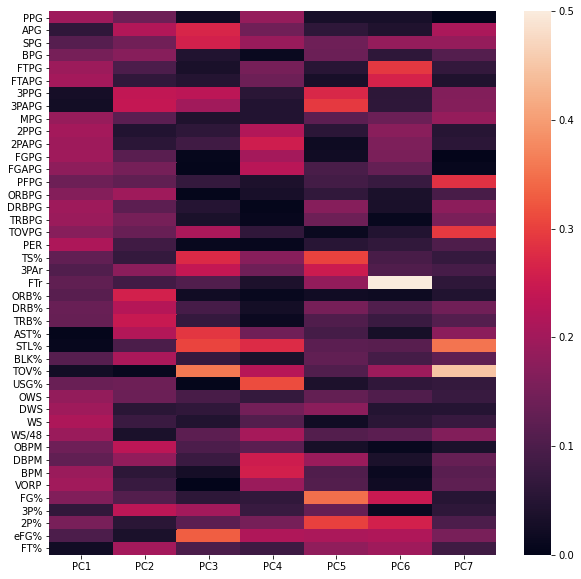

In [ ]:
pca_df = pca.PCA_transform(4) # run PCA for the first 4 components
pca.Heatmap() # heatmap of the PCs and variables

In [ ]:
pca.PCA_sorted_eigen('PC1')[:10] # eigenvalues for PC1

PER      0.213368
WS       0.213253
2PPG     0.204976
FTAPG    0.204149
VORP     0.200341
FGPG     0.198005
DWS      0.197327
PPG      0.196602
2PAPG    0.196093
DRBPG    0.195399
Name: PC1, dtype: float64

In [ ]:
pc1 = pca_df[['PLAYER','POSITION','PC1']].copy()
pc1.nlargest(10,'PC1') # players with largest PC1

,PLAYER,POSITION,PC1
108,David Robinson,C,16.425947
390,Shaquille O'Neal,C,15.639459
268,LeBron James,SG,14.260982
301,Michael Jordan,SG,14.106088
235,Karl Malone,PF,13.570824
66,Charles Barkley,PF,13.434438
135,Dwight Howard,PF,12.637634
262,Larry Bird,PF,12.546611
170,Hakeem Olajuwon,C,12.166146
417,Tim Duncan,PF,11.749949


In [ ]:
pca.PCA_sorted_eigen('PC2')[:10] # eigenvalues for PC2

ORB%     0.260647
TRB%     0.245873
3PAPG   -0.241479
3PPG    -0.237950
OBPM    -0.231424
3P%     -0.231379
DRB%     0.222899
AST%    -0.220361
APG     -0.219822
BLK%     0.210964
Name: PC2, dtype: float64

In [ ]:
pc2 = pca_df[['PLAYER','POSITION','PC2']].copy()
pc2.nlargest(10,'PC2') # players with largest PC2

,PLAYER,POSITION,PC2
34,Ben Wallace,C,8.637996
115,Dennis Rodman,SF,8.185085
393,Shawn Bradley,C,7.322580
72,Chris Andersen,C,7.208228
452,Wayne Cooper,C,7.168903
283,Marcus Camby,C,7.167196
204,Jeff Foster,C,6.793266
229,Jon Koncak,C,6.667335
135,Dwight Howard,PF,6.361740
324,Olden Polynice,C,6.305926


In [ ]:
pca.PCA_sorted_eigen('PC3')[:10] # eigenvalues for PC3

TOV%    -0.357532
eFG%     0.330591
STL%    -0.306069
AST%    -0.290125
TS%      0.274459
APG     -0.269333
SPG     -0.261157
3PAr     0.240276
3PPG     0.230736
TOVPG   -0.212561
Name: PC3, dtype: float64

In [ ]:
pc3 = pca_df[['PLAYER','POSITION','PC3']].copy()
pc3.nlargest(10,'PC3') # players with largest PC3

,PLAYER,POSITION,PC3
406,Steve Novak,SF,7.665967
291,Matt Bonner,C,6.078824
256,Kyle Korver,SF,5.130715
180,J.J. Redick,PG,4.870149
190,James Jones,SF,4.850204
333,Peja Stojakovic,SF,4.678468
453,Wesley Person,SG,4.065513
349,Reggie Miller,SG,4.011390
65,Channing Frye,C,3.743617
404,Steve Kerr,PG,3.663623


In [ ]:
pca.PCA_sorted_eigen('PC4')[:10] # eigenvalues for PC4

USG%    -0.313431
STL%     0.276772
BPM      0.258791
2PAPG   -0.254113
DBPM     0.253561
FGAPG   -0.227346
TOV%     0.224871
2PPG    -0.218764
eFG%     0.216104
WS/48    0.205109
Name: PC4, dtype: float64

In [ ]:
pc4 = pca_df[['PLAYER','POSITION','PC4']].copy()
pc4.nlargest(10,'PC4') # players with largest PC4

,PLAYER,POSITION,PC4
226,John Stockton,PG,6.025269
317,Nate McMillan,PG,5.703290
41,Bo Outlaw,SF,5.385106
78,Chris Paul,PG,4.979236
34,Ben Wallace,C,4.577216
49,Brent Barry,SG,4.478858
279,Magic Johnson,SG,4.408901
12,Amir Johnson,SF,4.248580
199,Jason Kidd,PG,4.088228
281,Manu Ginobili,SG,3.903417


In [ ]:
pca_df.head()

,PC1,PC2,PC3,PC4,PLAYER,TEAM,POSITION
0,2.243468,3.957355,1.136140,0.824272,A.C. Green,LAL,PF
1,-2.869484,0.675478,-1.562551,1.807450,Aaron McKie,POR,SG
2,-1.449472,5.971145,0.318407,0.397576,Aaron Williams,MIL,PF
3,-0.589926,0.844578,0.415611,-1.857021,Al Harrington,IND,PF
4,6.162854,2.342299,2.312704,1.459889,Al Horford,ATL,C


In [ ]:
data_scaled = Standard_Scaler_Preprocess(pca_df) # normalize and standardize the PCA for clustering
data_scaled.head()

,PC1,PC2,PC3,PC4,PLAYER,TEAM,POSITION
0,0.528160,1.309768,0.586434,0.461556,A.C. Green,LAL,PF
1,-0.675538,0.223563,-0.806532,1.012093,Aaron McKie,POR,SG
2,-0.341237,1.976273,0.164350,0.222625,Aaron Williams,MIL,PF
3,-0.138881,0.279530,0.214523,-1.039851,Al Harrington,IND,PF
4,1.450868,0.775232,1.193734,0.817474,Al Horford,ATL,C


In [ ]:
data_scaled.describe().round(1)  # check PCs are standardized

,PC1,PC2,PC3,PC4
count,459.0,459.0,459.0,459.0
mean,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0
min,-2.0,-2.6,-3.4,-2.8
25%,-0.7,-0.7,-0.6,-0.6
50%,-0.1,-0.1,0.1,0.0
75%,0.6,0.7,0.6,0.6
max,3.9,2.9,4.0,3.4


In [ ]:
num_data_scaled = data_scaled.drop(['PLAYER', 'POSITION', 'TEAM'], axis = 1) # keep numerical categories only
num_data_scaled.columns

Index(['PC1', 'PC2', 'PC3', 'PC4'], dtype='object')

## K-MEANS

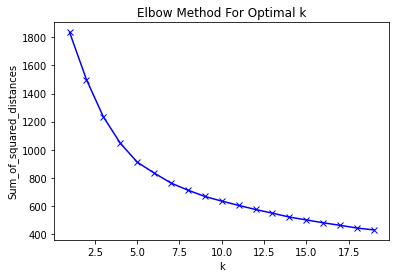

In [ ]:
# elbow test for K-means to predict appropiate number of clusters
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(num_data_scaled)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

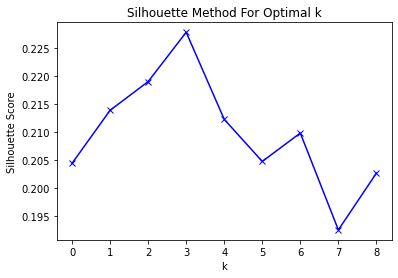

In [ ]:
# Silhouette test for K-means to predict appropiate number of clusters
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(num_data_scaled)
  labels = kmeans.labels_
  sil.append(silhouette_score(num_data_scaled, labels, metric = 'euclidean'))

plt.plot(sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [ ]:
# Run K-means for 6 clusters
X = num_data_scaled.copy()
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_

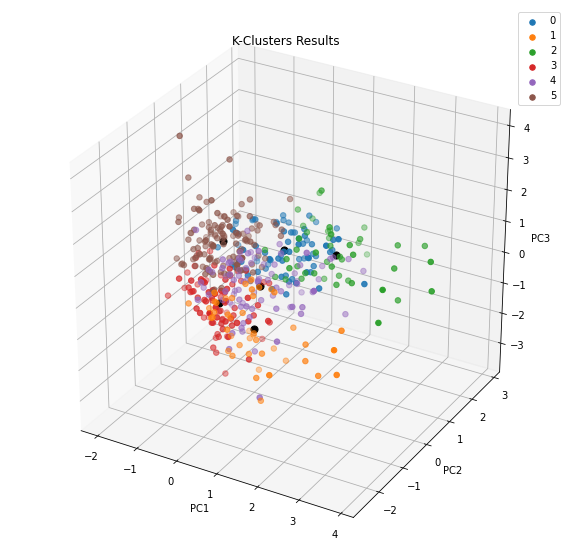

In [ ]:
# Plot Results
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
X['K-cluster'] = y_kmeans
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    x = np.array(X[X['K-cluster'] == i]['PC1'])
    y = np.array(X[X['K-cluster'] == i]['PC2'])
    z = np.array(X[X['K-cluster'] == i]['PC3'])
    ax.scatter(x, y, z, marker = 'o', s = 30)
plt.title('K-Clusters Results')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([0,1,2,3,4,5])
for i in range(6): ax.scatter(centers[i][0],centers[i][1],centers[i][2],marker = 'o', s = 50,c='black') # plot the centers
plt.show()

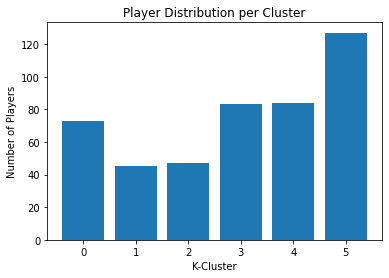

In [ ]:
# assign clusters to the players
data_scaled_k = data_scaled.copy()
data_scaled_k['K-cluster'] = y_kmeans
# Plot values per cluster
plt.bar([0,1,2,3,4,5],data_scaled_k['K-cluster'].value_counts().sort_index())
plt.xlabel('K-Cluster')
plt.ylabel('Number of Players')
plt.title('Player Distribution per Cluster')
plt.show()

In [ ]:
data_scaled_k['K-cluster'].value_counts().sort_index()

0     73
1     45
2     47
3     83
4     84
5    127
Name: K-cluster, dtype: int64

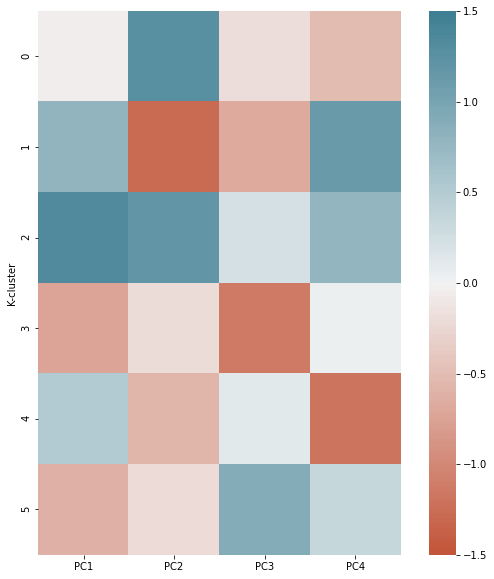

In [ ]:
# heatmap for each cluster 
plt.figure(figsize = (10,10))
sns.heatmap(data_scaled_k.groupby('K-cluster').mean(), vmin = -1.5, vmax = 1.5, center = 0, cmap = sns.diverging_palette(20, 220, n = 200), square = True)

In [ ]:
# Find Representative Players in the clusters
data_scaled_k[data_scaled_k['K-cluster'] == 5][['PLAYER','POSITION','K-cluster','PC3']].sort_values(['PC3'],ascending=False).head(10)

,PLAYER,POSITION,K-cluster,PC3
406,Steve Novak,SF,5,3.956893
291,Matt Bonner,C,5,3.137667
256,Kyle Korver,SF,5,2.648288
180,J.J. Redick,PG,5,2.513793
190,James Jones,SF,5,2.503498
333,Peja Stojakovic,SF,5,2.414854
453,Wesley Person,SG,5,2.098470
349,Reggie Miller,SG,5,2.070533
65,Channing Frye,C,5,1.932319
404,Steve Kerr,PG,5,1.891028


In [ ]:
# Save players classification for rookie cost analysis 
results = data_scaled_k[['PLAYER','K-cluster']].copy()
results = results.rename({'K-cluster' : 'CLUSTER'}, axis = 1)
results.to_csv('results-k-cluster.csv')

,PLAYER,CLUSTER
302,Michael Redd,4
320,Nick Anderson,5
142,Eduardo Najera,5
189,Jameer Nelson,5
254,Kris Humphries,0


## Complete Hierarchy

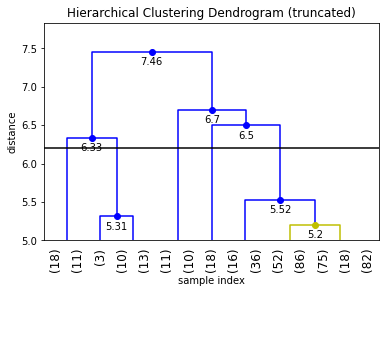

In [ ]:
data_scaled_c = data_scaled.copy()
# run complete linkage clustering
complete = Cluster(num_data_scaled, 'complete')
complete.dendrogram_truncated(15, 5, 6.2) # plot dendrogram

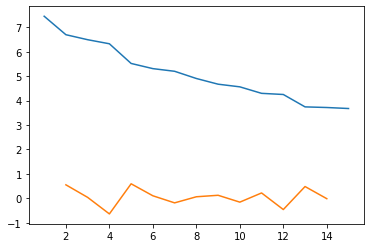

In [ ]:
complete.elbow_plot(15) # elbow and silhouette plot

In [ ]:
# Calculate Complete Clusters
data_scaled_c['complete_cluster'] = complete.create_cluster(6)
data_scaled_c['complete_cluster'].value_counts().sort_index()

1     29
2     26
3     21
4     18
5    365
Name: complete_cluster, dtype: int64

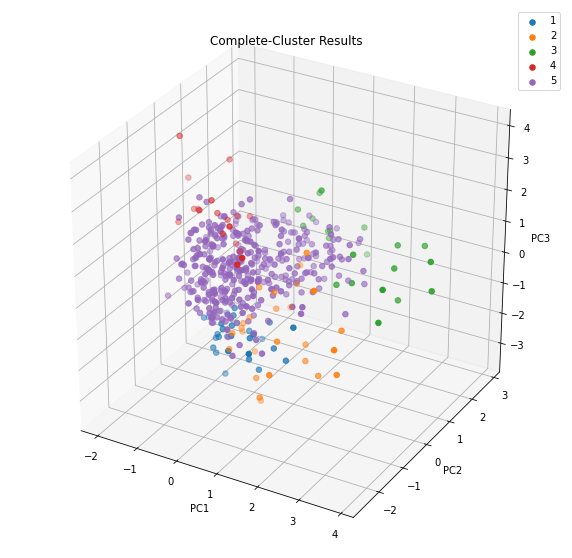

In [ ]:
# 3D plot results
X = data_scaled_c.copy()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(1,6):
    x = np.array(X[X['complete_cluster'] == i]['PC1'])
    y = np.array(X[X['complete_cluster'] == i]['PC2'])
    z = np.array(X[X['complete_cluster'] == i]['PC3'])
    ax.scatter(x, y, z, marker = 'o', s = 30)
plt.title('Complete-Cluster Results')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([1,2,3,4,5])
plt.show()

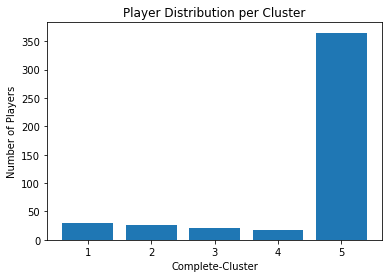

In [ ]:
# Plot values per cluster
plt.bar([1,2,3,4,5],data_scaled_c['complete_cluster'].value_counts().sort_index())
plt.xlabel('Complete-Cluster')
plt.ylabel('Number of Players')
plt.title('Player Distribution per Cluster')
plt.show()

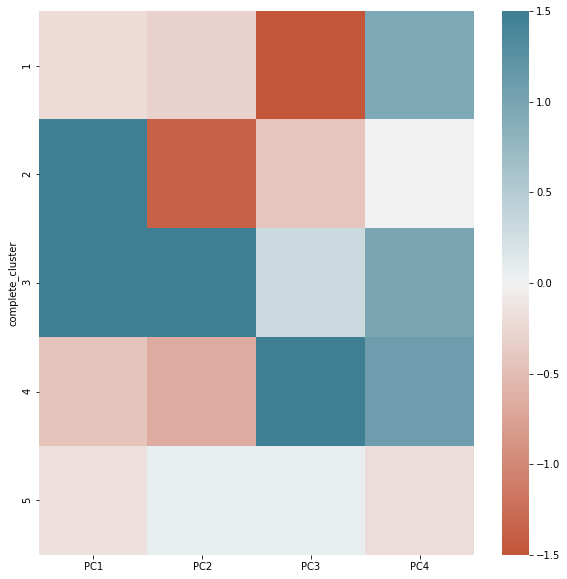

In [ ]:
# heatmap plot
plt.figure(figsize = (10,10))
sns.heatmap(data_scaled_c.groupby('complete_cluster').mean(), vmin = -1.5, vmax = 1.5, center = 0, cmap = sns.diverging_palette(20, 220, n = 200), square = True)

In [ ]:
# get representative players per cluster
data_scaled_c[data_scaled_c['complete_cluster'] == 5][['PLAYER','POSITION','complete_cluster','PC4']].sort_values(['PC4'],ascending=False).head(10)

,PLAYER,POSITION,complete_cluster,PC4
281,Manu Ginobili,SG,5,2.185743
17,Andrei Kirilenko,SF,5,2.047373
105,Darrell Armstrong,PG,5,1.962557
14,Andre Iguodala,SG,5,1.956378
228,Jon Barry,SG,5,1.932818
361,Robert Horry,SF,5,1.913329
414,Thabo Sefolosha,SG,5,1.855493
70,Charlie Ward,PG,5,1.852515
412,Terry Porter,PG,5,1.530838
380,Scott Brooks,PG,5,1.479929


In [ ]:
# Save results
res = data_scaled_c[['PLAYER','complete_cluster']].copy()
res = res.rename({'complete_cluster' : 'CLUSTER'}, axis = 1)
res.to_csv('results-complete.csv')

## SINGLE

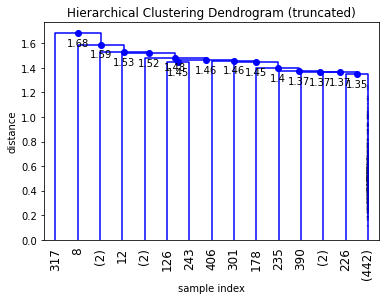

In [ ]:
data_scaled_s = data_scaled.copy()
# run single linkage clustering
single = Cluster(num_data_scaled, 'single')
single.dendrogram_truncated(15) # plot dendrogram

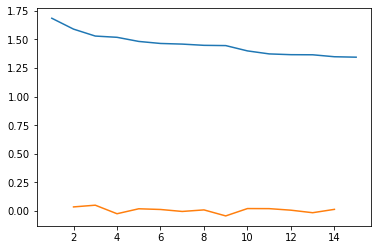

In [ ]:
single.elbow_plot(15) # elbow and silhouette plot

In [ ]:
# Inadequate for the given data (all players fall in one cluster)
data_scaled_s['single_cluster'] = single.create_cluster(1.5)
data_scaled_s['single_cluster'].value_counts()

2    454
1      2
5      1
4      1
3      1
Name: single_cluster, dtype: int64

## Average

0.6462838564130776


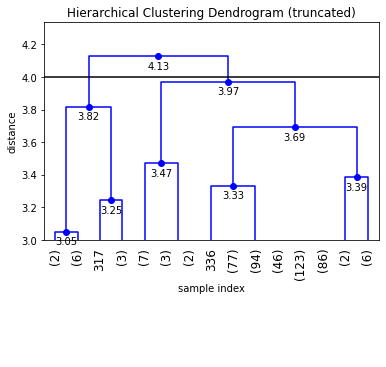

In [ ]:
data_scaled_a = data_scaled.copy()
# run average linkage clustering
average = Cluster(num_data_scaled, 'average')
average.dendrogram_truncated(15, 3, 4) # plot dendrogram

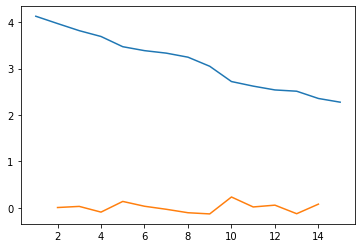

In [ ]:
average.elbow_plot(15) # silhouette and elbow plot

In [ ]:
# Inadequate for the given data
data_scaled_a['average_cluster'] = average.create_cluster(3.5)
data_scaled_a['average_cluster'].value_counts()

4    427
3     12
5      8
1      8
2      4
Name: average_cluster, dtype: int64

## WARD method

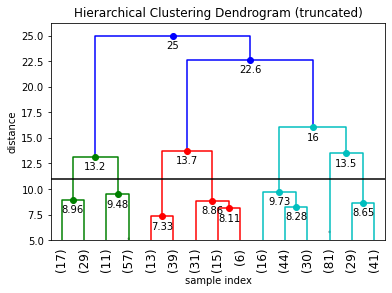

In [ ]:
# calculate ward linkage
data_scaled_w = data_scaled.copy()
ward = Cluster(num_data_scaled, 'ward')
ward.dendrogram_truncated(15, 5, 11)

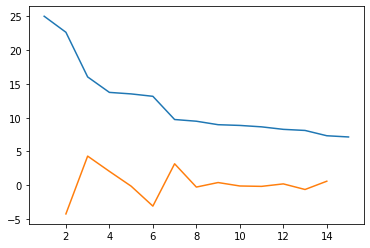

In [ ]:
# calculate elbow and silhouette plots
ward.elbow_plot(15)

In [ ]:
# Cluster the data
data_scaled_w['ward_cluster'] = ward.create_cluster(10)
data_scaled_w['ward_cluster'].value_counts().sort_index()

1    46
2    68
3    52
4    52
5    90
6    81
7    70
Name: ward_cluster, dtype: int64

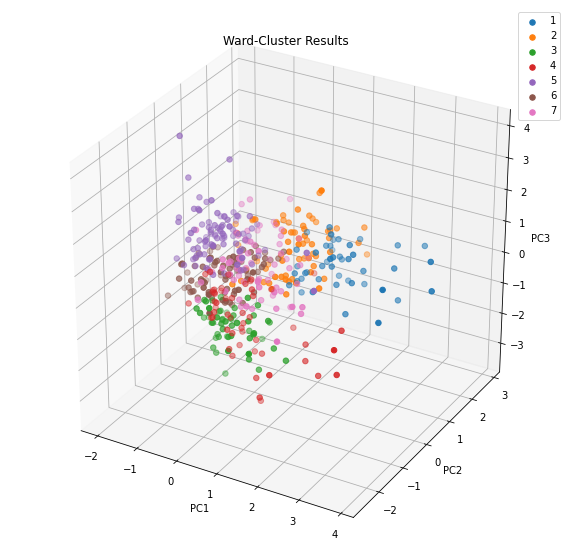

In [ ]:
# 3D plot results
X = data_scaled_w.copy()
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(1,8):
    x = np.array(X[X['ward_cluster'] == i]['PC1'])
    y = np.array(X[X['ward_cluster'] == i]['PC2'])
    z = np.array(X[X['ward_cluster'] == i]['PC3'])
    ax.scatter(x, y, z, marker = 'o', s = 30)
plt.title('Ward-Cluster Results')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([1,2,3,4,5,6,7])
plt.show()

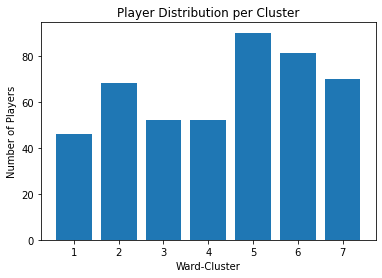

In [ ]:
# Plot values per cluster
plt.bar([1,2,3,4,5,6,7],data_scaled_w['ward_cluster'].value_counts().sort_index())
plt.xlabel('Ward-Cluster')
plt.ylabel('Number of Players')
plt.title('Player Distribution per Cluster')
plt.show()

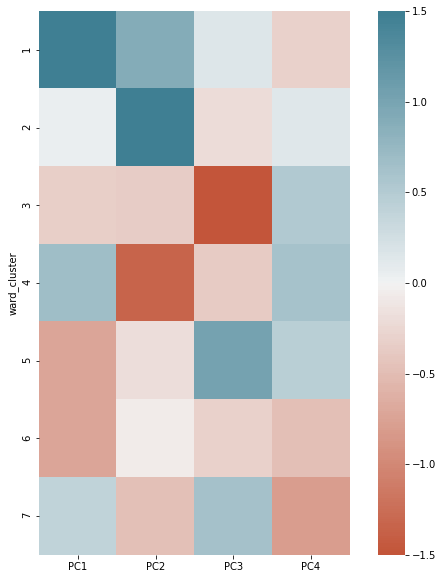

In [ ]:
# plot heatmap of PCs per Cluster
plt.figure(figsize = (10,10))
sns.heatmap(data_scaled_w.groupby('ward_cluster').mean(), vmin = -1.5, vmax = 1.5, center = 0, cmap = sns.diverging_palette(20, 220, n = 200), square = True)

In [ ]:
# results are very similar to K-means so discard

## END